# Module 03: Feature & Target Engineering

## Prerequisites

In [53]:
# Additional packages
# ! pip install -U missingno
# ! pip install -U category_encoders
# ! pip install -U feature_engine

In [54]:
# Helper packages
import missingno as msno
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, ggtitle

# Modeling pre-processing with scikit-learn functionality
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# Modeling pre-processing with non-scikit-learn packages
from category_encoders.ordinal import OrdinalEncoder
from feature_engine.encoding import RareLabelEncoder

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

In [55]:
# Ames housing data
ames = pd.read_csv("../../00-data/ML/ames.csv")

# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("Sale_Price", axis=1)
y_train = train[["Sale_Price"]]

# Target engineering

In [56]:
tt = TransformedTargetRegressor(transformer=PowerTransformer(method='box-cox'))
tt

TransformedTargetRegressor(transformer=PowerTransformer(method='box-cox'))

## Dealing with missingness

### Visualizing missing values

In [57]:
ames_raw = pd.read_csv("../../00-data/ML/ames_raw.csv")

# count missing values
ames_raw.isnull().sum()

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage      490
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 82, dtype: int64

<AxesSubplot:>

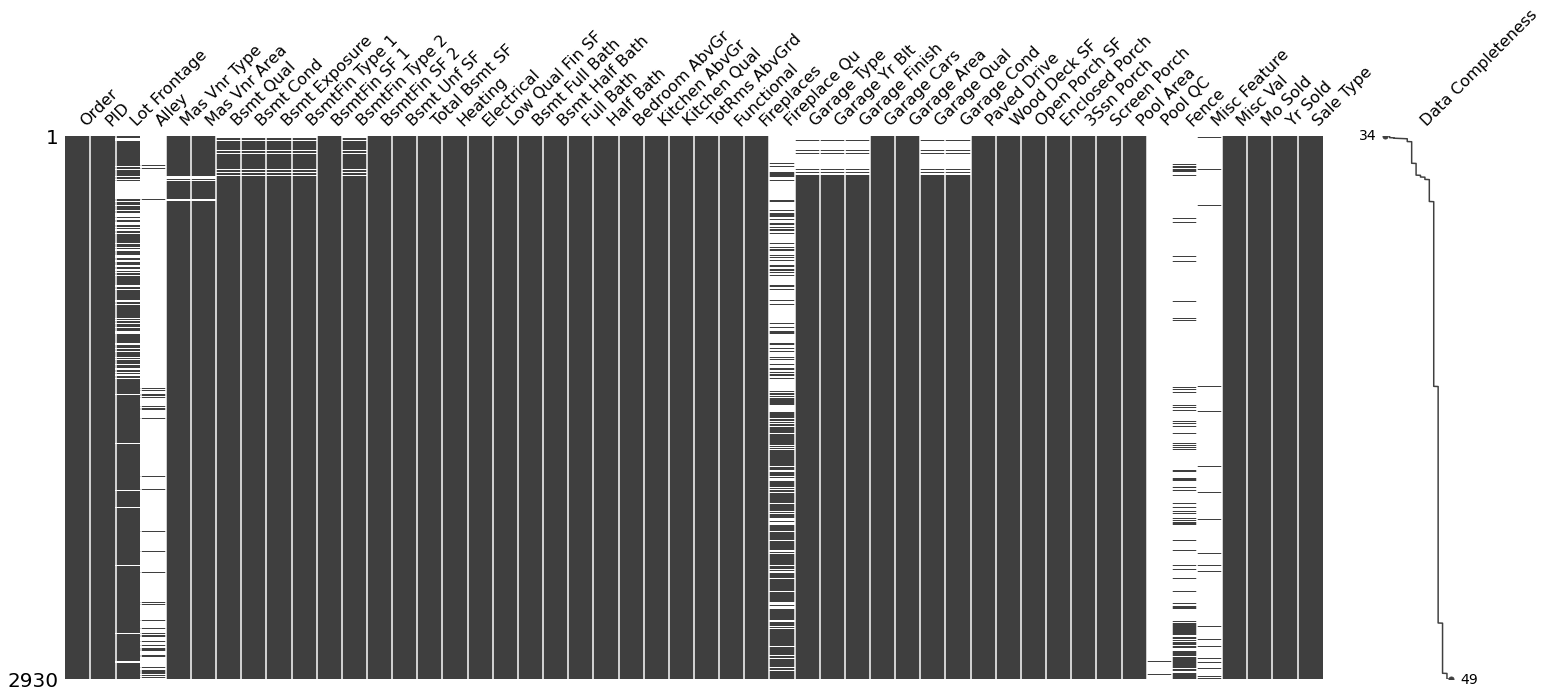

In [58]:
# can you identify patterns of missing data?
# missingness is represented with white
msno.matrix(ames_raw, labels=True, filter="bottom", sort="ascending", n=50)

<AxesSubplot:>

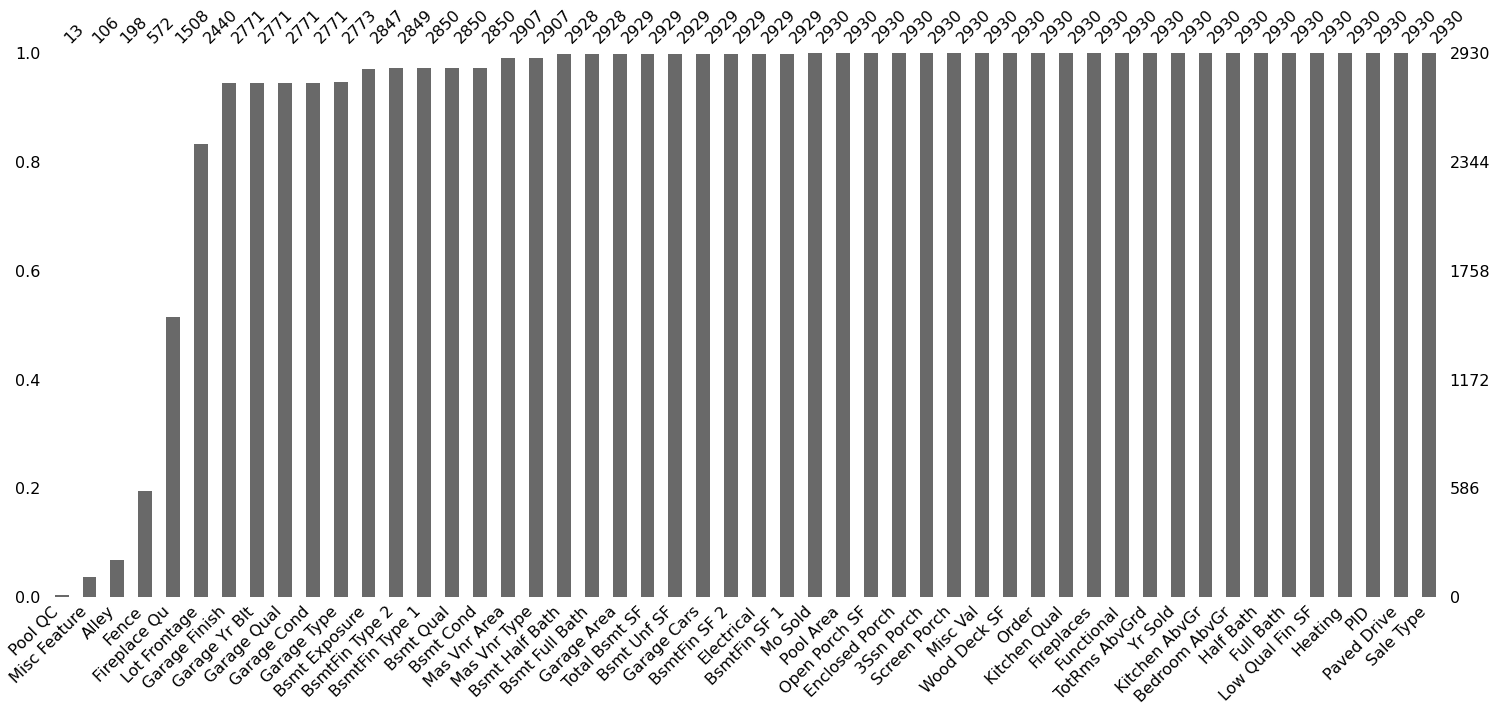

In [59]:
# which features have most missing?
# this chart shows the number of observations so small bars (i.e. Pool QC)
# represent very few observed values (lots of missingness)
msno.bar(ames_raw, labels=True, filter="bottom", sort="ascending", n=50)

### Imputation

#### Estimated statistic

In [60]:
# median imputation to all features
a = SimpleImputer(strategy='median')

# median imputation to just numeric predictors
b = ColumnTransformer([("num_imp", a, selector(dtype_include="number"))])

# median imputation to 1 or more features
c = ColumnTransformer([("num_imp", a, selector("Gr_Liv_Area"))])

#### K-nearest neighbor

In [61]:
knn_imp = KNNImputer(n_neighbors=6)

## Feature filtering

In [62]:
nzv = VarianceThreshold(threshold=0.1)

## Numeric feature engineering

### Skewness

In [63]:
# Normalizing approach
yj = PowerTransformer(method="yeo-johnson")

# Normalize all numeric features
X_norm = ColumnTransformer([("norm", yj, selector(dtype_include="number"))])

### Standardization

In [64]:
# Normalizing approach
scaler = StandardScaler()

# standardize all numeric features
std = ColumnTransformer([("norm", scaler, selector(dtype_include="number"))])

## Categorical feature engineering

### One-hot & dummy encoding

In [65]:
# one-hot encoder
encoder = OneHotEncoder()

# apply to all categorical features
ohe = ColumnTransformer([("one-hot", encoder, selector(dtype_include="object"))])

# dummy encode
encoder = OneHotEncoder(drop='first')

# apply to all categorical features
de = ColumnTransformer([("dummy", encoder, selector(dtype_include="object"))])

### Label encoding

In [66]:
# create encoder
encoder = LabelEncoder()

# Label encode a single column
lbl = ColumnTransformer([("label", encoder, "MS_SubClass")])

### Ordinal encoding

In [67]:
# ID all quality features to ordinal encode
cols = list(X_train.filter(regex=("Qual$|QC$|Cond$")).columns)

# specify levels in order
lvs = ["Very_Poor", "Poor", "Fair", "Below_Average", "Average", "Typical", 
       "Above_Average", "Good", "Very_Good", "Excellent", "Very_Excellent"]
val = range(0, len(lvs))

# create a level to integer mapping
lvl_map = dict(zip(lvs, val))
category_mapping = [{'col': col, 'mapping': lvl_map} for col in cols]

# example of first two mappings
category_mapping[0:2]

[{'col': 'Overall_Qual',
  'mapping': {'Very_Poor': 0,
   'Poor': 1,
   'Fair': 2,
   'Below_Average': 3,
   'Average': 4,
   'Typical': 5,
   'Above_Average': 6,
   'Good': 7,
   'Very_Good': 8,
   'Excellent': 9,
   'Very_Excellent': 10}},
 {'col': 'Overall_Cond',
  'mapping': {'Very_Poor': 0,
   'Poor': 1,
   'Fair': 2,
   'Below_Average': 3,
   'Average': 4,
   'Typical': 5,
   'Above_Average': 6,
   'Good': 7,
   'Very_Good': 8,
   'Excellent': 9,
   'Very_Excellent': 10}}]

In [68]:
# Apply ordinal encoder
cat_encoder = OrdinalEncoder(cols=cols, mapping=category_mapping)

### Lumping

In [69]:
# create rare label encoder
rare_encoder = RareLabelEncoder(tol=0.01, replace_with="other")

# demonstrate how some neighborhoods are now represented by "other"
rare_encoder.fit_transform(X_train)["Neighborhood"].unique()

/opt/conda/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:178: UserWarning: The number of unique categories for variable MS_Zoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
/opt/conda/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:178: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
/opt/conda/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:178: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
/opt/conda/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:178: UserWarning: The number of unique categories for variable Lot_Shape is less than that indicated in n_categories. Thus, all categories will be considered frequent
/opt/conda/lib/python3.9/site-p

array(['Mitchell', 'Sawyer', 'Edwards', 'College_Creek', 'Meadow_Village',
       'Northridge_Heights', 'Northwest_Ames', 'Northridge', 'Brookside',
       'Old_Town', 'Sawyer_West', 'Gilbert',
       'South_and_West_of_Iowa_State_University', 'Somerset', 'Crawford',
       'North_Ames', 'Clear_Creek', 'Iowa_DOT_and_Rail_Road',
       'Timberland', 'other', 'Stone_Brook', 'Bloomington_Heights'],
      dtype=object)

## Dimension reduction

In [70]:
# PCA object - keep 25 components
pca = PCA(n_components=25)

# apply PCA to all numeric features
pca_encoder = ColumnTransformer([("pca", pca, selector(dtype_include="number"))])

## Putting the process together

In [71]:
# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("Sale_Price", axis=1)
y_train = train["Sale_Price"]
X_test = test.drop("Sale_Price", axis=1)
y_test = test["Sale_Price"]

# create KNN model object
knn = KNeighborsRegressor()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = KFold(n_splits=10, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {'knn__n_neighbors': range(2, 26)}

In [72]:
# 1. Remove near-zero variance features that are categorical  
nzv_encoder = VarianceThreshold(threshold=0.1)

# 2. Ordinal encode our quality-based features 
ord_cols = list(X_train.filter(regex=("Qual$|QC$|Cond$")).columns)
lvs = ["Very_Poor", "Poor", "Fair", "Below_Average", "Average", "Typical", 
       "Above_Average", "Good", "Very_Good", "Excellent", "Very_Excellent"]
val = range(0, len(lvs))
lvl_map = dict(zip(lvs, val))


In [73]:
lvl_map

{'Very_Poor': 0,
 'Poor': 1,
 'Fair': 2,
 'Below_Average': 3,
 'Average': 4,
 'Typical': 5,
 'Above_Average': 6,
 'Good': 7,
 'Very_Good': 8,
 'Excellent': 9,
 'Very_Excellent': 10}

In [74]:



category_mapping = [{'col': col, 'mapping': lvl_map} for col in ord_cols]
ord_encoder = OrdinalEncoder(cols=ord_cols, mapping=category_mapping)
ord_encoder

OrdinalEncoder(cols=['Overall_Qual', 'Overall_Cond', 'Exter_Qual', 'Exter_Cond',
                     'Bsmt_Qual', 'Bsmt_Cond', 'Heating_QC', 'Kitchen_Qual',
                     'Garage_Qual', 'Garage_Cond', 'Pool_QC'],
               mapping=[{'col': 'Overall_Qual',
                         'mapping': {'Above_Average': 6, 'Average': 4,
                                     'Below_Average': 3, 'Excellent': 9,
                                     'Fair': 2, 'Good': 7, 'Poor': 1,
                                     'Typical': 5, 'Very_Excellent': 10,
                                     'Very_Good': 8, 'Very...
                        {'col': 'Garage_Cond',
                         'mapping': {'Above_Average': 6, 'Average': 4,
                                     'Below_Average': 3, 'Excellent': 9,
                                     'Fair': 2, 'Good': 7, 'Poor': 1,
                                     'Typical': 5, 'Very_Excellent': 10,
                                     'Very_Good'

In [75]:

# 3. Center and scale (i.e., standardize) all numeric features
scaler = StandardScaler()

# 4. Perform dimension reduction by applying PCA to all numeric features
pca = PCA(n_components=30)

# 5. One-hot encode remaining categorical features.
encoder = OneHotEncoder(handle_unknown="ignore")


In [76]:

# combine all steps into a preprocessing pipeline
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("nzv_encode", nzv_encoder, selector(dtype_include="number")),
  ("ord_encode", ord_encoder, ord_cols),
  ("std_encode", scaler, selector(dtype_include="number")),
  ("pca_encode", pca, selector(dtype_include="number")),
  ("one-hot", encoder, selector(dtype_include="object")),
  ])

In [77]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('nzv_encode', VarianceThreshold(threshold=0.1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0xffff4297de80>),
                                ('ord_encode',
                                 OrdinalEncoder(cols=['Overall_Qual',
                                                      'Overall_Cond',
                                                      'Exter_Qual',
                                                      'Exter_Cond', 'Bsmt_Qual',
                                                      'Bsmt_Cond', 'Heating_QC',
                                                      'Kitchen_Qual',
                                                      'Garage_Qual',
                                                      'Garage_...
                                ('std_encode', StandardScaler(),
                                 <sklearn.compose._column_transformer.

In [78]:
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("knn", knn),
])

In [79]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nzv_encode',
                                                  VarianceThreshold(threshold=0.1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0xffff4297de80>),
                                                 ('ord_encode',
                                                  OrdinalEncoder(cols=['Overall_Qual',
                                                                       'Overall_Cond',
                                                                       'Exter_Qual',
                                                                       'Exter_Cond',
                                                                       'Bsmt_Qual',
                                                                       'Bsmt_Cond',
                                               

In [80]:
# Tune a knn model using grid search
grid_search = GridSearchCV(model_pipeline, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)

41915.58187389292

In [81]:
# Best model's k value
results.best_estimator_.get_params().get('knn__n_neighbors')

5

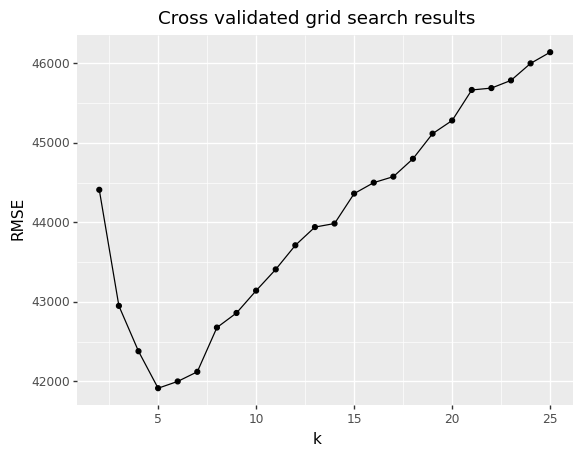

<ggplot: (17591985260276)>

: 

In [82]:
# Plot all RMSE results
all_rmse = pd.DataFrame({'k': range(2, 26), 
                         'RMSE': np.abs(results.cv_results_['mean_test_score'])})

(ggplot(all_rmse, aes(x='k', y='RMSE'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))

## Exercises

Using the Ames dataset and the same approach shown in the [last section](#engineering-process-example):

1. Rather than use a 70% stratified training split, try an 80% unstratified training split. How does your cross-validated results compare?

2. Rather than numerically encode the quality and condition features (i.e. `step_integer(matches("Qual|Cond|QC"))`), one-hot encode these features.  What is the difference in the number of features in your training set?  Apply the same cross-validated KNN model to this new feature set. How does the performance change? How does the training time change?

3. Identify three new feature engineering steps that are provided by [recipes](https://recipes.tidymodels.org/), [scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) or some other open source R/Python package:
   - Why would these feature engineering steps be applicable to the Ames data?
   - Apply these feature engineering steps along with the same cross-validated KNN model. How do your results change?
   
4. Using the [Attrition data set](https://misk-data-science.github.io/misk-homl/docs/01-introduction.nb.html#the_data_sets), assess the characteristics of the target and features.
   - Which target/feature engineering steps should be applied?
   - Create a feature engineering pipeline and apply a KNN grid search. What is the performance of your model?